# Lab 4: Quantum Optimization (QAOA for Max-Cut)

**Welcome to Lab 4!** In our last lab, we explored a hybrid quantum-classical workflow for **data classification** (Quantum Kernels). In this lab, we'll explore another, even more popular hybrid workflow for **combinatorial optimization**.

We will tackle a famous NP-Hard problem called **Max-Cut** using the **Quantum Approximate Optimization Algorithm (QAOA)**. This is a very different approach to QML—instead of a quantum feature map, we'll use a quantum circuit as a "trainable solver" to find the best answer to a complex problem.

---

## Learning Objectives

* Understand what a **combinatorial optimization** problem is and what **NP-Hard** means.
* Learn the mathematics of the **Max-Cut** problem.
* Understand how to map a classical problem into a quantum **Hamiltonian** (an "energy" operator).
* Learn the theory behind **QAOA**: what are the "Problem" and "Mixer" circuits?
* Build and run a full hybrid QAOA loop to solve a Max-Cut problem.
* Discuss the "promise" of QAOA and whether it provides a quantum advantage.

---

## Recap from Lab 3 (The Hybrid Loop)

In Lab 3, you saw a **hybrid quantum-classical** workflow.
1.  **Quantum Computer:** Did one specific job (computed a kernel $K(x_i, x_j)$).
2.  **Classical Computer:** Did all the "thinking" (ran the SVM, trained the model).

QAOA uses a similar hybrid loop, but it's much more dynamic. The classical computer will be a "trainer" (like a neural network optimizer) that actively "tunes" the parameters of the quantum circuit to find a solution.

---

## Part 1: The Problem (What is Max-Cut?)

**Combinatorial optimization** is a fancy term for "finding the best needle in a giant haystack." You have a finite (but astronomically large) number of possible solutions, and you need to find the *best* one.

A classic example is the **Max-Cut** problem.

1.  **You have a graph** $G = (V, E)$, made of vertices (nodes) $V$ and edges (links) $E$.
2.  **Your goal** is to partition all vertices into two sets (let's call them **Set 0** and **Set 1**).
3.  You want to **maximize the number of edges** that "cross" the partition (i.e., connect a node in Set 0 to a node in Set 1).



---

### The Math of Max-Cut

How do we represent this for a computer? With a **bitstring!**

If we have $N$ vertices, we can use an $N$-bit string, $z = z_1 z_2 ... z_N$, to describe any possible partition:
* If $z_i = 0$, vertex $i$ is in **Set 0**.
* If $z_i = 1$, vertex $i$ is in **Set 1**.

An edge $(i, j)$ is "cut" if $z_i \neq z_j$.

Our goal is to find the string $z$ that maximizes a **cost function** $C(z)$, which just counts the total number of cut edges.

$$C(z) = \sum_{(i,j) \in E} C_{ij}(z)$$

Where $C_{ij}(z) = 1$ if $z_i \neq z_j$, and $0$ otherwise.

**Example:** For the string $z = 0101$ on the 4-node graph above:
* Edge (0, 1): $z_0=0, z_1=1$. Cut! (1)
* Edge (0, 3): $z_0=0, z_3=1$. Cut! (1)
* Edge (1, 2): $z_1=1, z_2=0$. Cut! (1)
* Edge (2, 3): $z_2=0, z_3=1$. Cut! (1)
* Edge (1, 3): $z_1=1, z_3=1$. Not cut. (0)
* **Total Cost:** $C(0101) = 4$. (This is the optimal solution!)

### Why is this hard? (NP-Hard)

For a graph with $N$ nodes, there are $2^N$ possible bitstrings (partitions).
* 4 nodes = $2^4 = 16$ solutions. We can check them all by hand.
* 50 nodes = $2^{50} \approx 10^{15}$ solutions. Impossible to brute-force.

This "exponential explosion" is the hallmark of an **NP-Hard** problem. There is no known classical algorithm that can *find the perfect solution* efficiently for all graphs. We must rely on **heuristics** (algorithms that find "pretty good" approximate answers). QAOA is a new type of quantum heuristic.

---

## Part 2: From Classical Problem to Quantum Hamiltonian

This is the most important theoretical step. How do we "explain" our problem to a quantum computer?

We translate our *classical cost function* $C(z)$ into a *quantum **Hamiltonian*** $H_P$.

### What is a Hamiltonian? 

Don't let the word scare you. A **Hamiltonian** is just a matrix that describes the **total energy** of a system.
* Every possible state of the system (like our bitstring $z$) has an energy.
* A fundamental law of physics is that **systems *prefer* to be in their lowest energy state.**
* This lowest energy state is called the **"ground state."**

**The Central Idea:** We will build a Hamiltonian $H_P$ such that the **ground state (lowest energy)** corresponds *exactly* to the **best solution** of our Max-Cut problem.

### The Mapping

To do this, we need a mathematical "trick." Our $z_i \in \{0, 1\}$ bits are slightly awkward. It's much cleaner to use $s_i \in \{+1, -1\}$.
* $z_i = 0 \rightarrow s_i = +1$ (Set 0)
* $z_i = 1 \rightarrow s_i = -1$ (Set 1)

Now, look at the product $s_i s_j$:
* If $s_i, s_j$ are in the **same set** (+1,+1) or (-1,-1), then $s_i s_j = +1$.
* If $s_i, s_j$ are in **different sets** (+1,-1) or (-1,+1), then $s_i s_j = -1$.

This is perfect! Our cost function "counts 1" for different sets. The term $\frac{1}{2}(1 - s_i s_j)$ does exactly this:
* **Same set:** $\frac{1}{2}(1 - (+1)) = 0$. (No cost)
* **Different sets:** $\frac{1}{2}(1 - (-1)) = 1$. (Cost of 1)

So, our *total cost function* to **maximize** is:
$$C(s) = \sum_{(i,j) \in E} \frac{1}{2}(1 - s_i s_j)$$

### The Final Step: Bits to Qubits

In quantum computing, we have the **Pauli-Z operator** ($Z$).
* When you measure a qubit in the Z-basis, you get an *eigenvalue* of $+1$ (for state $|0\rangle$) or $-1$ (for state $|1\rangle$).
* **This is the mapping!** We just replace our classical variable $s_i$ (which is $\pm 1$) with the quantum operator $Z_i$ (which *measures* $\pm 1$).

Our classical cost function $C(s)$ becomes our **Problem Hamiltonian $H_P$**:

$$H_P = \sum_{(i,j) \in E} \frac{1}{2}(I - Z_i Z_j)$$

*(We use $Z_i Z_j$ to mean $Z \otimes Z$ acting on qubits $i$ and $j$, and $I$ on all others).*

Now, finding the bitstring $s$ that maximizes $C(s)$ is *identical* to finding the quantum state $|s\rangle$ that **maximizes the "expectation value"** $\langle s | H_P | s \rangle$.

*(Note: Most physics problems seek to *minimize* energy. QAOA can do either, but we'll ask Qiskit to *maximize* this "cost" $H_P$.)*


In [1]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

---
## Part 3: The Algorithm (QAOA)

So, we have $H_P$. How do we find the state $|s\rangle$ that maximizes its energy? We can't check all $2^N$ states.

We will **use a quantum computer to prepare a "guess" state $|\psi\rangle$** and then measure it. If we build our guess state *cleverly*, it will have a high probability of collapsing to the *best* answer $s_{\text{max}}$.

QAOA is the "recipe" for building this guess state. It's a **variational** algorithm, which means our circuit has "knobs" (parameters) that a classical optimizer will tune.

The QAOA circuit has three parts:
1.  **Start (Superposition):** We begin by putting all qubits in a uniform superposition with Hadamard gates ($H^{\otimes N}$). This creates the state $|+\rangle^{\otimes N}$, which is an equal guess of all $2^N$ possible bitstrings at once.
2.  **The "Problem" Circuit ($U_P$):** We apply our $H_P$. This applies a "phase shift" to each bitstring based on its cost $C(s)$. This is where the graph structure is encoded.
    $$U_P(\gamma) = e^{-i \gamma H_P} = \prod_{(i,j) \in E} e^{-i \frac{\gamma}{2}(I - Z_i Z_j)}$$
    (Don't worry about the $e$ and $i$, just know that $e^{-i\gamma Z_i Z_j}$ is a $R_{ZZ}(\gamma)$ gate in Qiskit. This circuit block consists of **two-qubit $R_{ZZ}$ gates** on all the edges.)
3.  **The "Mixer" Circuit ($U_M$):** This circuit "mixes" the solutions, allowing our guess to "move" from one bitstring to another. The standard mixer is:
    $$U_M(\beta) = e^{-i \beta \sum_k X_k} = \prod_k e^{-i \beta X_k}$$
    (This is just a **single-qubit $R_X(2\beta)$ gate** on *every* qubit.)

The full circuit (called an "Ansatz") just repeats these two blocks $p$ times:

$|\psi(\vec{\gamma}, \vec{\beta})\rangle = U_M(\beta_p) U_P(\gamma_p) \cdots U_M(\beta_1) U_P(\gamma_1) |+\rangle^{\otimes N}$

The angles $(\vec{\gamma}, \vec{\beta})$ are the **$2p$ parameters** we need to train. The number $p$ is the "depth" of the algorithm.



This leads to the **hybrid loop**:
1.  **Classical Optimizer** picks angles $(\vec{\gamma}, \vec{\beta})$.
2.  **QPU** builds the circuit, runs it, and measures.
3.  **QPU** calculates the average cost $\langle H_P \rangle$ from the measurements.
4.  **Classical Optimizer** gets the cost and "nudges" the angles to get a *better* cost.
5.  Repeat until the cost stops improving.

---

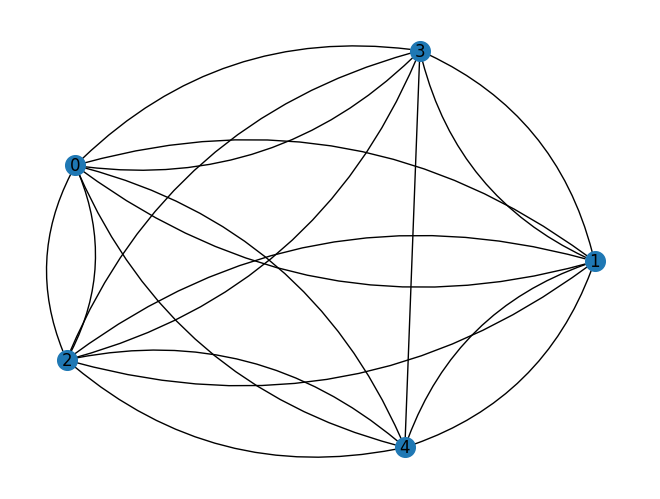

In [2]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

In [3]:
for u, v in graph.edge_list():
    print(f"{u} -- {v}")

0 -- 1
1 -- 0
0 -- 2
2 -- 0
0 -- 3
3 -- 0
0 -- 4
4 -- 0
1 -- 2
2 -- 1
1 -- 3
3 -- 1
1 -- 4
4 -- 1
2 -- 3
3 -- 2
2 -- 4
4 -- 2
3 -- 4


In [4]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []

    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
 
        weight = graph.get_edge_data(edge[0], edge[1])
 
        pauli_list.append(("".join(paulis)[::-1], weight))
 
    # --- End of TODO ---
    return pauli_list

max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


## Part 4: Building the QAOA Circuit (The "Ansatz")

Now we have our problem Hamiltonian $H_P$. Our goal is to find the bitstring $|s\rangle$ that *minimizes* the energy $\langle s | H_P | s \rangle$.

We can't test all $2^N$ bitstrings. Instead, we'll build a **parameterized quantum circuit** (called an "Ansatz") to prepare a "guess" state. This state, $|\psi(\vec{\gamma}, \vec{\beta})\rangle$, is a superposition of all possible answers, but it's "biased" toward the good ones.

The QAOA circuit is built in three steps:

1.  **Start (Superposition):** We apply a Hadamard ($H$) gate to every qubit. This creates a uniform superposition of all $2^N$ possible bitstrings, $|+\rangle^{\otimes N}$. This is our "blank slate" guess.

2.  **Apply Problem Circuit ($U_P$):** We apply our $H_P$ for a time $\gamma$. This circuit "marks" the good solutions (low-cost bitstrings) by rotating their phase.
    $$U_P(\gamma) = e^{-i \gamma H_P}$$
    This circuit is built from **$R_{ZZ}(\gamma)$ gates** for every edge $(i,j)$ in our graph.

3.  **Apply Mixer Circuit ($U_M$):** We apply a "mixer" Hamiltonian. This allows our quantum state to "move" between different solutions (e.g., from bitstring `0101` to `1101`).
    $$U_M(\beta) = e^{-i \beta \sum_k X_k}$$
    This circuit is just an **$R_X(2\beta)$ gate** on *every* qubit.

The full circuit, for $p=1$ "reps", is just these steps in order. The angles $\gamma$ and $\beta$ are the **trainable parameters** (the "knobs" on our solver).

$|\psi(\gamma, \beta)\rangle = U_M(\beta) U_P(\gamma) |+\rangle^{\otimes N}$

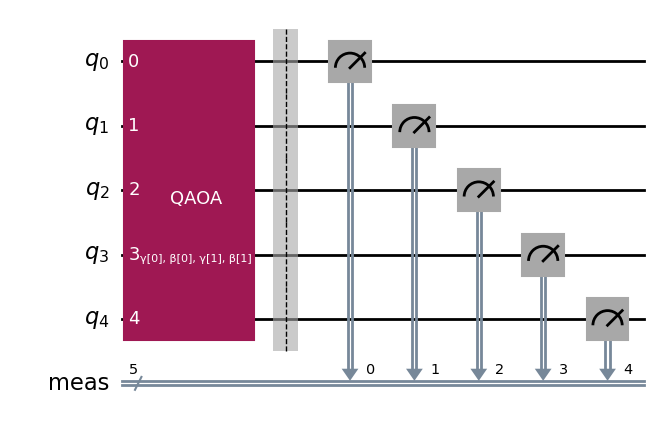

In [5]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

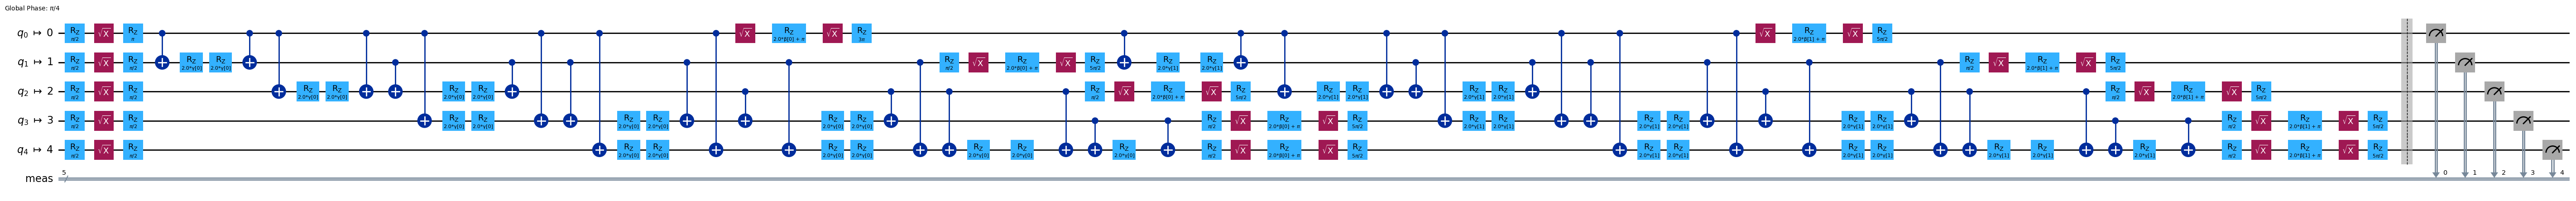

In [6]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

In [7]:
init_params = np.zeros(2 * layers)

## Part 4: Defining the Cost Function (The Hybrid Loop)

We now have a circuit *template* (the Ansatz) and parameters $(\gamma, \beta)$ that we can "tune." How do we know which angles are "good"?

We create a **cost function** that our classical optimizer can understand. This function defines the **hybrid quantum-classical loop**:

1.  **Input:** The classical optimizer passes in a set of parameters (e.g., `[gamma, beta]`).
2.  **Quantum Job:** Our function:
    a. Takes the `ansatz` circuit.
    b. Binds the new `[gamma, beta]` parameters to it.
    c. Executes the circuit on a quantum backend (or simulator).
    d. Measures the results (gets the counts for `0011`, `1010`, etc.).
3.  **Output:** The function computes the **average cost (or "expectation value")** $\langle H_P \rangle$ over all the measured bitstrings. This single number tells the optimizer how "good" that set of parameters was.

This function is the "black box" that the classical optimizer will try to minimize.

In [8]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost

## Part 5: Running the Classical Optimizer

We now have all the pieces:
1.  `ansatz`: Our parameterized quantum circuit.
2.  `cost_func`: A function that takes parameters, runs the circuit, and returns a cost.
3.  `initial_point`: A random first guess for $\gamma$ and $\beta$.

We can now hand all of this to a **classical optimizer**, like `COBYLA` or `minimize`.

The optimizer will:
1.  Call `cost_func` with the `initial_point` to get a "baseline" cost.
2.  Based on this cost, it will "nudge" the parameters $\gamma$ and $\beta$ in a direction it thinks will *lower* the cost.
3.  It will call `cost_func` again with the new parameters.
4.  It will repeat this process (dozens or hundreds of times) until it finds a set of parameters that gives the *lowest possible cost* (the "minimum").

The final output will be the set of **optimal parameters** (e.g., `best_gamma`, `best_beta`) that "solve" our problem.

In [9]:
def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.724092759072409
       x: [ 9.735e-01  9.780e-01 -5.691e-01  1.029e+00]
    nfev: 63
   maxcv: 0.0


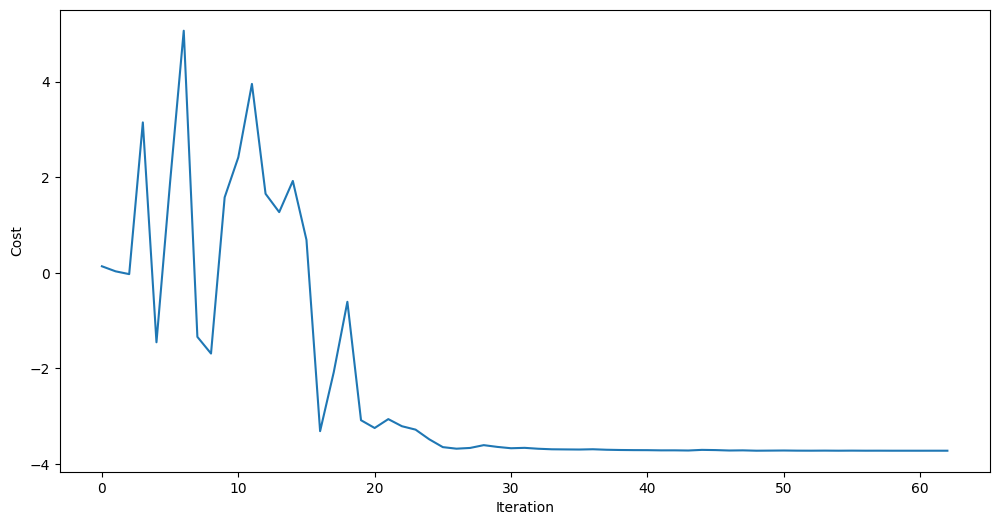

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Interpreting the Cost Function Plot

This plot is the "learning curve" of the classical optimizer.

* **Y-axis (Cost):** This is the "average energy" $\langle H_P \rangle$ calculated by the `cost_func`. A lower value is better, as it means we are finding a state that better minimizes our problem Hamiltonian (and thus maximizes the cuts).
* **X-axis (Iteration):** This is each time the `COBYLA` optimizer "nudged" the parameters ($\gamma, \beta$) and called our `cost_func` again.

You can see that the optimizer starts with a random `initial_point`, which gives a high (bad) cost. It then quickly "learns," finding parameters that dramatically lower the cost. The plot flattens out at the end, which means the optimizer has **converged**—it has found the best parameters ($\gamma_{\text{opt}}, \beta_{\text{opt}}$) it can for this $p=1$ circuit.

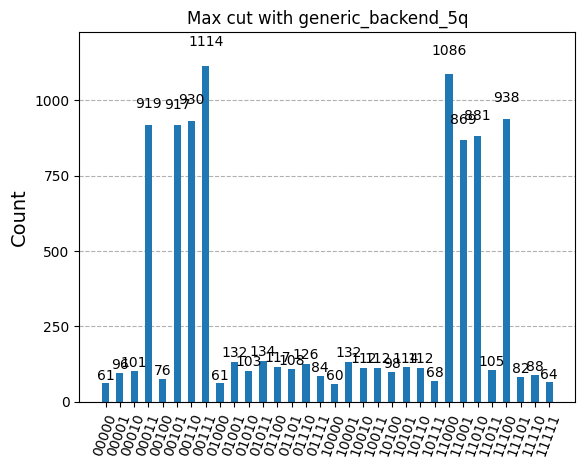

In [11]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

In [14]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


### Interpreting the Final Solution Histogram (5-node Max-Cut)

This histogram shows the **final samples** from running the ansatz one last time with the best parameters found by the optimizer.

- **X-axis (bitstrings):** All $$2^5 = 32$$ possible assignments of 5 nodes to two sets (0/1).
- **Y-axis (counts):** How many times each bitstring was measured (probability ≈ counts / shots).

For this 5-node graph, the cost Hamiltonian has **ground energy** equal to the maximum cut and it is **8-fold degenerate** (there are eight optimal bitstrings).  
From the exact diagonalization we found the optimal indices  
$$\{3,5,6,7,24,25,26,28\}$$  
which in 5-bit binary are:
00011, 00101, 00110, 00111, 11000, 11001, 11010, 11100

These appear in the histogram as the **tallest bars**. They come in **complement pairs** that represent the *same partition* (flipping all bits swaps the two sets without changing the cut):
- `00011` ↔ `11100`
- `00101` ↔ `11010`
- `00110` ↔ `11001`
- `00111` ↔ `11000`

Because QAOA is variational and we sample with finite shots, the eight optimal bitstrings need not have identical heights, but most of the probability mass concentrates on this optimal set. This indicates the $p=1$ QAOA successfully learned the **maximum-cut solutions** for the given graph.

*Note:* If your strings look reversed, check your bit order convention (LSB/MSB) when converting integers to bitstrings.


In [13]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


## Part 7: Final Conclusions

In this lab, we have:

1.  **Mapped an NP-hard problem (Max-Cut) to a quantum cost Hamiltonian** $H_C$. The **ground states** of $H_C$ correspond to **maximum-cut partitions** of the graph.

2.  **Implemented QAOA ($p = 1$)** as a hybrid loop: we optimized angles $\gamma, \beta$ for the ansatz $U_M(\beta)U_C(\gamma)$ with a classical optimizer and sampled the final state.

3.  **Recovered the optimal (degenerate) solutions for a 5-node graph.**
    The exact ground space is **8-fold degenerate** with bitstrings
    $\{00011, 00101, 00110, 00111, 11000, 11001, 11010, 11100\}$.
    Our final histogram concentrates probability mass on these strings (in **complement pairs** such as $00011 \leftrightarrow 11100$), confirming we reached the **maximum-cut value** for this graph.

> Note: Complementary bitstrings represent the *same partition* (swapping the two sets). Small differences in the bar heights arise from finite-shot sampling and optimization noise.

### The "Quantum Advantage?" (The "So What?")

You just solved an NP-Hard problem with a quantum computer! But... was it *faster*?

This is the most important question in the field.
* **No Proven Speedup:** QAOA is a **heuristic**, just like the best classical approximation algorithms. There is **no mathematical proof** that QAOA will *ever* be faster or better than classical heuristics.
* **The Problem:** For a small, constant $p$ (like $p=1, 2, 3$), the algorithm is fast, but it's not guaranteed to find the *perfect* answer (though it did for our simple graph). It finds a "good" approximation.
* **The (Physics) Theorem:** There is a theorem that as $p \rightarrow \infty$ (an infinitely deep circuit), QAOA *is* guaranteed to find the perfect, optimal solution. But we can't build an infinitely deep circuit due to noise.
* **The (Research) Hope:** The *hope* of QAOA is that for a *small* $p$, it will find a **better-quality approximation** than any known *fast* classical heuristic.

This is a **massive, open area of research**. QAOA is not a magic bullet, but it's a powerful new tool in the "optimizer's" toolbox and a perfect example of a useful, hybrid algorithm you can run *today*.

## 📚 References

The content, structure, and examples in these labs were heavily inspired by and adapted from the following official Qiskit and IBM Quantum resources:

* **IBM Quantum Learning:** The "Quantum Machine Learning" course, which provides detailed modules on both Quantum Kernels and the Quantum Approximate Optimization Algorithm (QAOA).
    * URL: `https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning`

* **Qiskit Global Summer School 2025:** Course materials and lectures on quantum algorithms and machine learning.

* **The Qiskit Textbook:** An open-source textbook for learning quantum computing with Qiskit, particularly the sections on QML and QAOA.
    * URL: `https://qiskit.org/textbook/`